In [179]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [180]:
df=pd.read_csv("test1.csv")
df.head()
df.columns = df.columns.str.strip()


In [181]:
df = df.dropna()
print(df['Close'].isnull().sum())


0


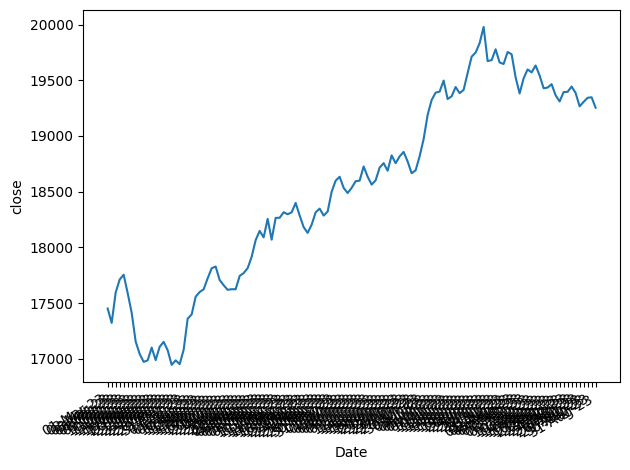

In [182]:
fig, ax = plt.subplots()

ax.plot(df.Date, df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('close')


fig.autofmt_xdate()
plt.tight_layout()



In [183]:
ad_fuller_result=adfuller(df['Close'])
print(f'adf fuller:{ad_fuller_result[0]}')
print(f'p value:{ad_fuller_result[1]}')


adf fuller:-0.9671426427000288
p value:0.7650588821882176


In [184]:
diff_df=np.diff(df['Close'],n=1)

ad_fuller_result = adfuller(diff_df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.496662263485257
p-value: 3.533991790184382e-16


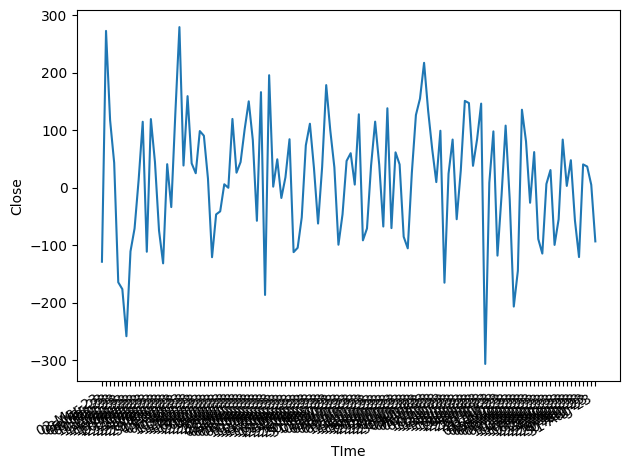

In [185]:
fig, ax = plt.subplots()

ax.plot(df['Date'][1:], diff_df)
ax.set_xlabel('TIme')
ax.set_ylabel('Close')



fig.autofmt_xdate()
plt.tight_layout()

In [186]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [187]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [195]:
train = df['Close'][:-5]

result_df = optimize_ARIMA(train, order_list, d)
result_df

100%|██████████| 16/16 [00:00<00:00, 19.43it/s]


,"(p,q)",AIC
0,"(2, 3)",1425.463704
1,"(2, 2)",1428.875639
2,"(1, 0)",1428.978195
3,"(0, 1)",1429.162658
4,"(0, 0)",1429.277546
5,"(3, 3)",1429.915158
6,"(2, 0)",1430.787505
7,"(1, 1)",1430.799978
8,"(0, 2)",1430.884589
9,"(0, 3)",1432.433765


In [196]:
model = SARIMAX(train, order=(2,3,1), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  118
Model:               SARIMAX(2, 3, 1)   Log Likelihood                -714.208
Date:                Fri, 01 Sep 2023   AIC                           1436.415
Time:                        01:14:12   BIC                           1447.395
Sample:                             0   HQIC                          1440.872
                                - 118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5202      0.094     -5.559      0.000      -0.704      -0.337
ar.L2         -0.2770      0.101     -2.755      0.006      -0.474      -0.080
ma.L1         -0.9999     15.379     -0.065      0.9

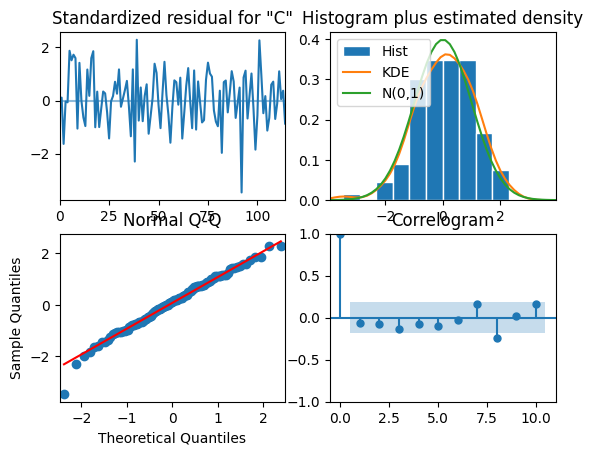

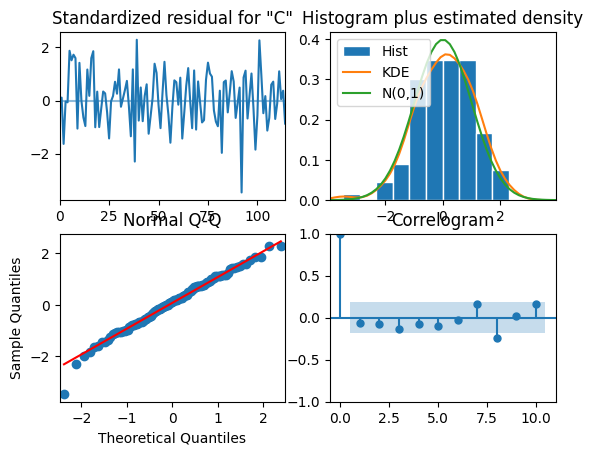

In [197]:
model_fit.plot_diagnostics()

In [198]:
residuals = model_fit.resid
pvalue=[]
pvalue = acorr_ljungbox(residuals, lags=None)

print(pvalue)

      lb_stat     lb_pvalue
1   40.931187  1.576846e-10
2   41.946675  7.787448e-10
3   41.947941  4.115493e-09
4   41.953853  1.705311e-08
5   41.959621  6.002277e-08
6   41.959806  1.872680e-07
7   41.963887  5.283888e-07
8   41.964250  1.375327e-06
9   41.964262  3.336356e-06
10  41.964263  7.609268e-06


In [199]:
import pandas as pd



# Now you can use .iloc[-30:] to select the last 30 rows
test = df.iloc[-5:]



test['naive_seasonal'] = df['Close'].iloc[-10:-5].values
test

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal
119,25-Aug-23,19297.40,19339.55,19229.70,19265.80,466518217.0,24998.12,19310.15
120,28-Aug-23,19298.35,19366.85,19249.70,19306.05,248178769.0,18237.22,19393.60
121,29-Aug-23,19374.85,19377.90,19309.10,19342.65,307388116.0,22501.12,19396.45
122,30-Aug-23,19433.45,19452.80,19334.75,19347.45,233004568.0,19877.49,19444.00
123,31-Aug-23,19375.55,19388.20,19223.65,19253.80,562557215.0,45699.54,19386.70


In [200]:
ARIMA_pred = model_fit.get_prediction(119, 123).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal,ARIMA_pred
119,25-Aug-23,19297.40,19339.55,19229.70,19265.80,466518217.0,24998.12,19310.15,19356.883264
120,28-Aug-23,19298.35,19366.85,19249.70,19306.05,248178769.0,18237.22,19393.60,19328.239125
121,29-Aug-23,19374.85,19377.90,19309.10,19342.65,307388116.0,22501.12,19396.45,19303.960082
122,30-Aug-23,19433.45,19452.80,19334.75,19347.45,233004568.0,19877.49,19444.00,19279.337901
123,31-Aug-23,19375.55,19388.20,19223.65,19253.80,562557215.0,45699.54,19386.70,19251.002709


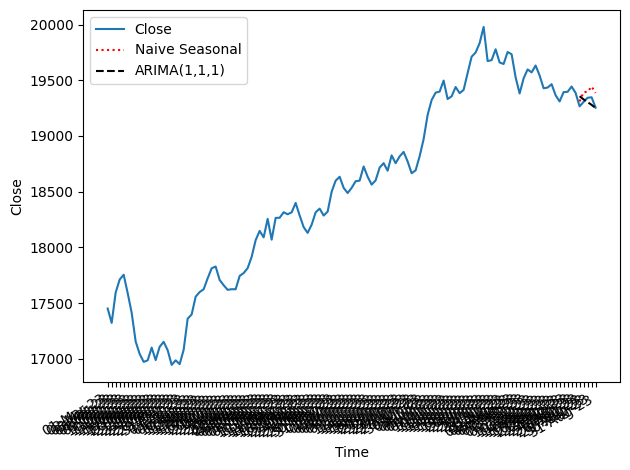

In [201]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'], label='Close')
ax.plot(test['Date'], test['naive_seasonal'], 'r:', label='Naive Seasonal')
ax.plot(test['Date'], test['ARIMA_pred'], 'k--', label='ARIMA(1,1,1)')

ax.set_xlabel('Time')
ax.set_ylabel('Close')
#ax.axvspan(pd.Timestamp('2023-08-01'), pd.Timestamp('2023-08-23'), color='#808080', alpha=0.2)

ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()

plt.show()
